<h1>Bidirectional GRU</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/"Colab Notebooks"/horse2zebra1.zip

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [9]:
import pandas as pd
#data = pd.read_csv('/content/drive/MyDrive/"Colab Notebooks"/Birmingham-mean.csv')
data = pd.read_csv('/content/drive/MyDrive/Birmingham-mean.csv')
data.head()

,Date,tmean
0,1879-01-01,42.5
1,1879-01-02,33.5
2,1879-01-03,16.0
3,1879-01-04,17.0
4,1879-01-05,24.0


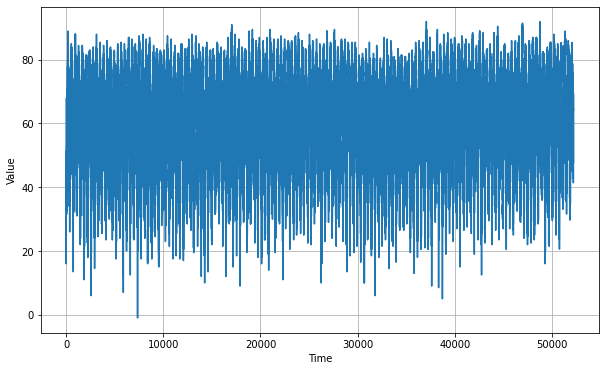

In [10]:
import csv
time_step = []
temps = []

##with open('Birmingham-mean.csv') as csvfile:  ##########
with open('/content/drive/MyDrive/Birmingham-mean.csv') as csvfile:    
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [11]:
split_time = 40000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:]

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100)), 
  tf.keras.layers.Dense(1),
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(40000,)
Epoch 1/100
156/156 [==============================] - 34s 98ms/step - loss: 1314.6432 - mae: 32.1358
Epoch 2/100
156/156 [==============================] - 15s 95ms/step - loss: 350.5127 - mae: 15.8520
Epoch 3/100
156/156 [==============================] - 15s 97ms/step - loss: 157.6747 - mae: 10.6801
Epoch 4/100
156/156 [==============================] - 17s 109ms/step - loss: 101.9457 - mae: 8.4987
Epoch 5/100
156/156 [==============================] - 15s 94ms/step - loss: 79.1449 - mae: 7.3003
Epoch 6/100
156/156 [==============================] - 15s 94ms/step - loss: 70.1389 - mae: 6.6864
Epoch 7/100
156/156 [==============================] - 15s 92ms/step - loss: 67.4691 - mae: 6.4445
Epoch 8/100
156/156 [==============================] - 15s 93ms/step - loss: 66.6157 - mae: 6.3527
Epoch 9/100
156/156 [=========

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 200)        61800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              181200    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 243,201
Trainable params: 243,201
Non-trainable params: 0
_________________________________________________________________


In [16]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

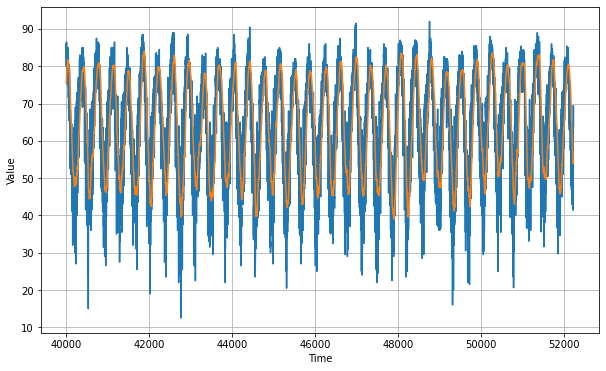

In [18]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.7020135

mean absolute error = 7.7020135

In [20]:
model.save('Bi_GRU_model.h5')

In [21]:
model = tf.keras.models.load_model('Bi_GRU_model.h5')